In [1]:
# import cv2
import numpy as np
# from tqdm import tqdm # progress bar for loops
import os
import tensorflow as tf

DATASET_FOLER = "alzheimers-dataset"
TRAINING_FOLER = DATASET_FOLER + "/" + "train"
TESTING_FOLER = DATASET_FOLER + "/" + "test"
IMAGE_HEIGHT=64
IMAGE_WIDTH=64
COLOR_MODE='grayscale'
IMAGE_CHANNELS = 3 if COLOR_MODE=='rgb' else 1
PATIENCE = 25
EPOCHS = 100
BATCH_SIZE = 16

train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAINING_FOLER,
    color_mode=COLOR_MODE,
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    subset='training',
    validation_split=0.2,
    seed=42,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAINING_FOLER,
    color_mode=COLOR_MODE,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    subset='validation',
    validation_split=0.2,
    seed=42,
)



Found 5753 files belonging to 4 classes.
Using 4603 files for training.
Found 5753 files belonging to 4 classes.
Using 1150 files for validation.


['C0_Mild_Demented', 'C1_Moderate_Demented', 'C2_Non_Demented', 'C3_Very_Mild_Demented']
(64, 64, 1)
(64, 64, 1)
(64, 64, 1)
(64, 64, 1)
(64, 64, 1)
(64, 64, 1)
(64, 64, 1)
(64, 64, 1)
(64, 64, 1)


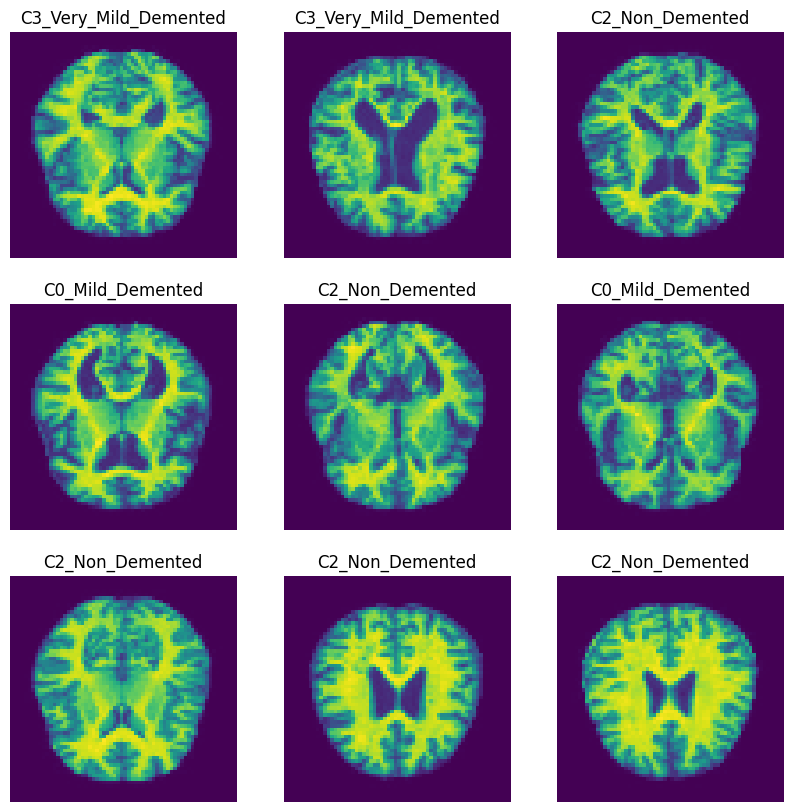

In [2]:
class_names = train_ds.class_names
print(class_names)


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    print(images[i].shape)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [3]:
import tensorflow as tf
from tensorflow import keras

preprocessing = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_HEIGHT, IMAGE_WIDTH),
    tf.keras.layers.Rescaling(1./255),
])

data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal_and_vertical"),
    keras.layers.RandomRotation(1),
    keras.layers.RandomTranslation(0.2, 0.2),
    keras.layers.RandomZoom(0.2),
    keras.layers.RandomBrightness(0.2),
    keras.layers.RandomContrast(0.2),
])

# train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)

In [4]:
model = keras.models.Sequential([
    keras.layers.Input(shape=(None, None, IMAGE_CHANNELS)),

    preprocessing,

    keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2),

    keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2),

    keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2),
    
    keras.layers.Conv2D(128, 3, padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2),

    # keras.layers.Conv2D(256, 3, padding="same", activation="relu"),
    # # keras.layers.BatchNormalization(momentum=0.87),
    # keras.layers.MaxPooling2D(),

    # keras.layers.GlobalAveragePooling2D(),

    # keras.layers.Dropout(0.4),

    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation="relu"),
    # keras.layers.Dropout(0.2),
    keras.layers.Dense(1024, activation="relu"),
    # keras.layers.Dropout(0.2),
    keras.layers.Dense(128, activation="relu"),
    # keras.layers.Dropout(0.2),
    keras.layers.Dense(4, activation="softmax"),
])


model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

model.summary(
    expand_nested=True,
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 1)         0         
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| resizing (Resizing)       (None, 64, 64, 1)         0         |
|                                                               |
| rescaling (Rescaling)     (None, 64, 64, 1)         0         |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 conv2d (Conv2D)             (None, 64, 64, 16)        160       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 16)       64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                    

In [5]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

earlystop_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[earlystop_loss],
    # class_weight=class_weights,
)

Epoch 1/100
288/288 [==============================] - 8s 18ms/step - loss: 1.2017 - sparse_categorical_accuracy: 0.5281 - val_loss: 8.5656 - val_sparse_categorical_accuracy: 0.5113
Epoch 2/100
288/288 [==============================] - 4s 15ms/step - loss: 0.8586 - sparse_categorical_accuracy: 0.5964 - val_loss: 1.7449 - val_sparse_categorical_accuracy: 0.5426
Epoch 3/100
288/288 [==============================] - 4s 15ms/step - loss: 0.7415 - sparse_categorical_accuracy: 0.6700 - val_loss: 0.8150 - val_sparse_categorical_accuracy: 0.6191
Epoch 4/100
288/288 [==============================] - 4s 15ms/step - loss: 0.5986 - sparse_categorical_accuracy: 0.7386 - val_loss: 0.9048 - val_sparse_categorical_accuracy: 0.6200
Epoch 5/100
288/288 [==============================] - 4s 15ms/step - loss: 0.4053 - sparse_categorical_accuracy: 0.8416 - val_loss: 0.5315 - val_sparse_categorical_accuracy: 0.7722
Epoch 6/100
288/288 [==============================] - 4s 15ms/step - loss: 0.2781 - spars

Epochs run: 39


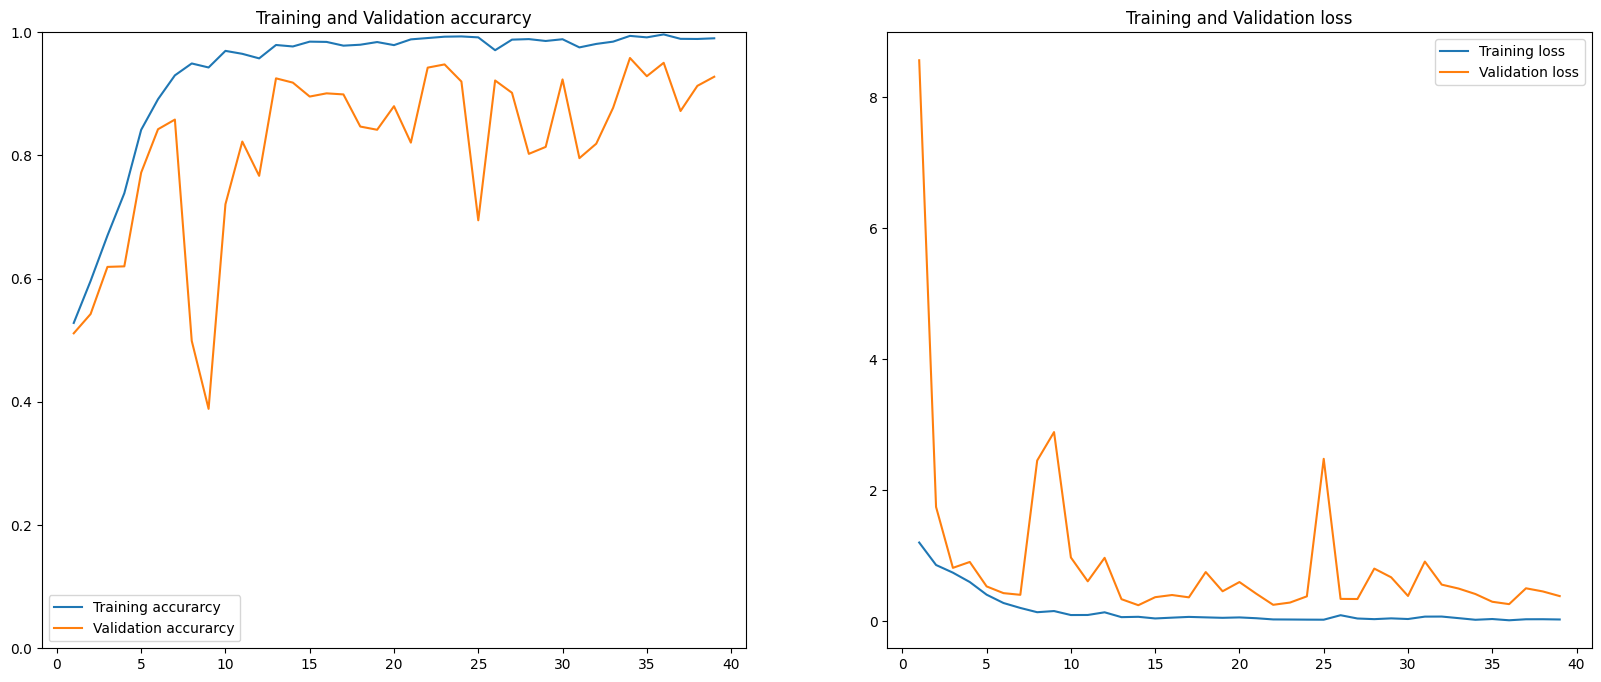

In [6]:
from matplotlib import pyplot as plt

print("Epochs run:", len(history.history["loss"]))

acc = history.history["sparse_categorical_accuracy"]
val_acc = history.history["val_sparse_categorical_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)

# Train and validation accuracy
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.ylim((0, 1))
plt.plot(epochs, acc, label="Training accurarcy")
plt.plot(epochs, val_acc, label="Validation accurarcy")
plt.title("Training and Validation accurarcy")
plt.legend()

# Train and validation loss
plt.subplot(1, 2, 2)

plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.title("Training and Validation loss")
plt.legend()
plt.show()

In [7]:
test_ds = keras.utils.image_dataset_from_directory(TESTING_FOLER,color_mode=COLOR_MODE,)

results = model.evaluate(test_ds, verbose=0)

print("Test accuracy:", results[1]*100)
print("Test loss:", results[0]*100)

Found 647 files belonging to 4 classes.
Test accuracy: 83.61669182777405
Test loss: 52.499425411224365


In [8]:
# SAVING THE MODEL
# save the classification model
model.save("alzheimers-cnn.h5")

In [9]:
import tensorflow as tf

model.save("alzheimers-cnn.h5") 
loaded_model = tf.keras.models.load_model("alzheimers-cnn.h5") 
loss, accuracy = loaded_model.evaluate(test_ds) 


21/21 [==============================] - 1s 15ms/step - loss: 0.5250 - sparse_categorical_accuracy: 0.8362
